# Exploring a `SegmentDataset` object created on the set of 192 replays from RLCS Worlds 2024

In [1]:
# Imports
from impulse import ReplayDataset
from impulse.preprocessing import SegmentedDataset
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
project_root = Path('/Users/david/dev/impulse')
data_dir = project_root / 'replays' / 'parsed'
db_path = project_root / 'impulse.db'

replay_dataset = ReplayDataset(db_path=str(db_path), data_dir=str(data_dir))

In [3]:
segmented_dataset = SegmentedDataset(replay_dataset, seed=42)

Found 192 parsed replays in database


In [4]:
all_train_segments = segmented_dataset.train_segments_list()
len(all_train_segments)

618

In [5]:
type(all_train_segments[0])

impulse.preprocessing.segmentation.ReplaySegment

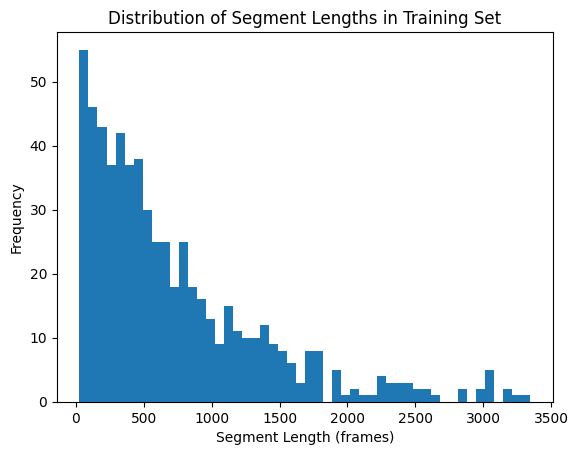

In [6]:
all_segment_lengths = [len(segment.frames) for segment in all_train_segments]

plt.hist(all_segment_lengths, bins=50)
plt.xlabel('Segment Length (frames)')
plt.ylabel('Frequency')
plt.title('Distribution of Segment Lengths in Training Set')
plt.show()

In [7]:
print('Segment length mean:', np.mean(all_segment_lengths))
print('Segment length median:', np.median(all_segment_lengths))
print('Segment length min:', np.min(all_segment_lengths))
print('Segment length max:', np.max(all_segment_lengths))

Segment length mean: 724.6472491909385
Segment length median: 518.5
Segment length min: 26
Segment length max: 3348


Let's cut out any segments shorter than 3 seconds or longer than 5 minutes. Since the dataset was parsed at 10 FPS, this corresponds to excluding segments shorter than 30 frames or longer than 3000 frames. 

We'll distinguish the original, unfiltered list of training segments from the filtered and further-processed list of segments by calling the former `all_train_segments` and the latter just `train_segments`. 

In [8]:
print('Number of training segments before filtering for length:', len(all_train_segments))
train_segments = [segment for segment in all_train_segments if 30 <= len(segment) <= 3000]
print('Number of training segments after filtering for length:', len(train_segments))

Number of training segments before filtering for length: 618
Number of training segments after filtering for length: 605


In [9]:
percent_cut = (len(all_train_segments) - len(train_segments))/len(all_train_segments) * 100 
round(percent_cut, 2)

2.1

This filter eliminated around 2.10% of the segments we originally had. 

Now that we've explored our data around the row dimension, let's look at the columns.

In [10]:
import random
random.seed(123)

rand_segment = random.choice(train_segments)
print('Randomly selected segment frames shape:', rand_segment.frames.shape)
rand_segment.frames.head()

Randomly selected segment frames shape: (540, 161)


,frame,current time,frame time,seconds remaining,Ball - position x,Ball - position y,Ball - position z,Ball - linear velocity x,Ball - linear velocity y,Ball - linear velocity z,...,p7_angular velocity z,p7_quaternion x,p7_quaternion y,p7_quaternion z,p7_quaternion w,p7_boost level,p7_dodge active,p7_jump active,p7_double jump active,p7_player demolished by
0,298,58.385578,58.389545,273.0,43.189999,-24.400000,190.279999,1021.840027,-1049.959961,1739.790039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,299,58.485577,58.489544,273.0,162.179993,-146.660004,388.130005,1018.200012,-1046.180054,1657.859985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,300,58.585575,58.589542,273.0,263.829987,-251.100006,550.130005,1015.080017,-1042.939941,1587.849976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,301,58.685574,58.689541,272.0,365.170013,-355.220001,705.140015,1011.960022,-1039.699951,1518.069946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,302,58.785572,58.789539,272.0,449.380005,-441.739990,828.989990,1009.359985,-1037.000000,1460.079956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This segment has `161` columns. As can be seen, it contains extra columns for the features for up to 8 players (e.g. `p6_position x`, `p6_position y`, etc.) despite being a replay for a 3v3 game. This is because the parser pads the `ReplayData.frames` dataframe to accomodate up to 8 players in a replay. Since these extra columns contain no information, let's drop them. 

In [11]:
for seg in train_segments:
    seg.frames.dropna(axis=1, how='all', inplace=True)

In [12]:
print('Randomly selected segment frames shape after dropping empty columns:', rand_segment.frames.shape)

Randomly selected segment frames shape after dropping empty columns: (540, 125)


Now we only have 125 features in our dataframe, each one carrying some relevant information. Let's begin to explore these.

## Ball features

In [13]:
all_cols_list = list(rand_segment.frames.columns)
ball_cols_list = [col for col in all_cols_list if 'Ball' in col]
print('Ball columns:', ball_cols_list)

Ball columns: ['Ball - position x', 'Ball - position y', 'Ball - position z', 'Ball - linear velocity x', 'Ball - linear velocity y', 'Ball - linear velocity z', 'Ball - angular velocity x', 'Ball - angular velocity y', 'Ball - angular velocity z', 'Ball - quaternion x', 'Ball - quaternion y', 'Ball - quaternion z', 'Ball - quaternion w']


In [14]:
ball_cols_dict = {
    'position' : [col for col in ball_cols_list if 'position' in col],
    'linear_velocity' : [col for col in ball_cols_list if 'linear velocity' in col],
    'angular_velocity' : [col for col in ball_cols_list if 'angular velocity' in col],
    'rotation' : [col for col in ball_cols_list if 'quaternion' in col]
}
ball_cols_dict

{'position': ['Ball - position x', 'Ball - position y', 'Ball - position z'],
 'linear_velocity': ['Ball - linear velocity x',
  'Ball - linear velocity y',
  'Ball - linear velocity z'],
 'angular_velocity': ['Ball - angular velocity x',
  'Ball - angular velocity y',
  'Ball - angular velocity z'],
 'rotation': ['Ball - quaternion x',
  'Ball - quaternion y',
  'Ball - quaternion z',
  'Ball - quaternion w']}

In [19]:
print('Cols in list:',len(ball_cols_list), '\tCols in dict:', sum(len(v) for v in ball_cols_dict.values()))

Cols in list: 13 	Cols in dict: 13


In [20]:
ball_frames_all_segments = pd.concat([seg.frames[ball_cols_list] for seg in train_segments], ignore_index=True)

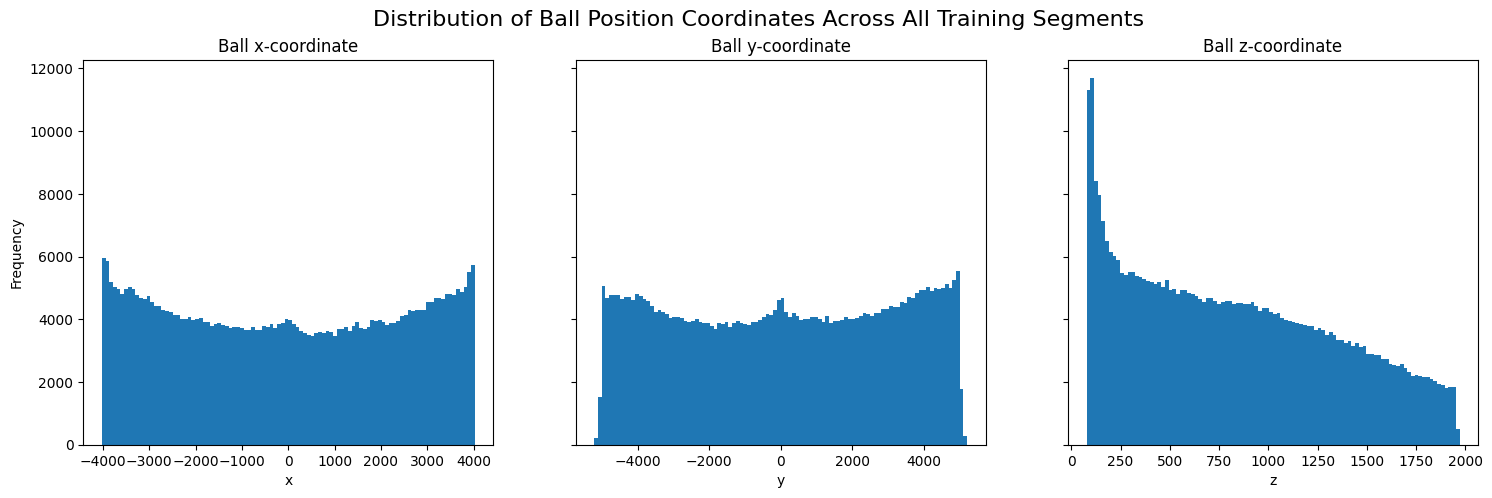

In [57]:
ball_pos_all_segments = ball_frames_all_segments[ball_cols_dict['position']]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

ax1.hist(ball_pos_all_segments[ball_cols_dict['position'][0]], bins=100)
ax1.set_xlabel('x')
ax1.set_ylabel('Frequency')
ax1.set_title('Ball x-coordinate')

ax2.hist(ball_pos_all_segments[ball_cols_dict['position'][1]], bins=100)
ax2.set_xlabel('y')
ax2.set_title('Ball y-coordinate')

ax3.hist(ball_pos_all_segments[ball_cols_dict['position'][2]], bins=100)
ax3.set_xlabel('z')
ax3.set_title('Ball z-coordinate')

fig.suptitle('Distribution of Ball Position Coordinates Across All Training Segments', fontsize=16)
plt.show()

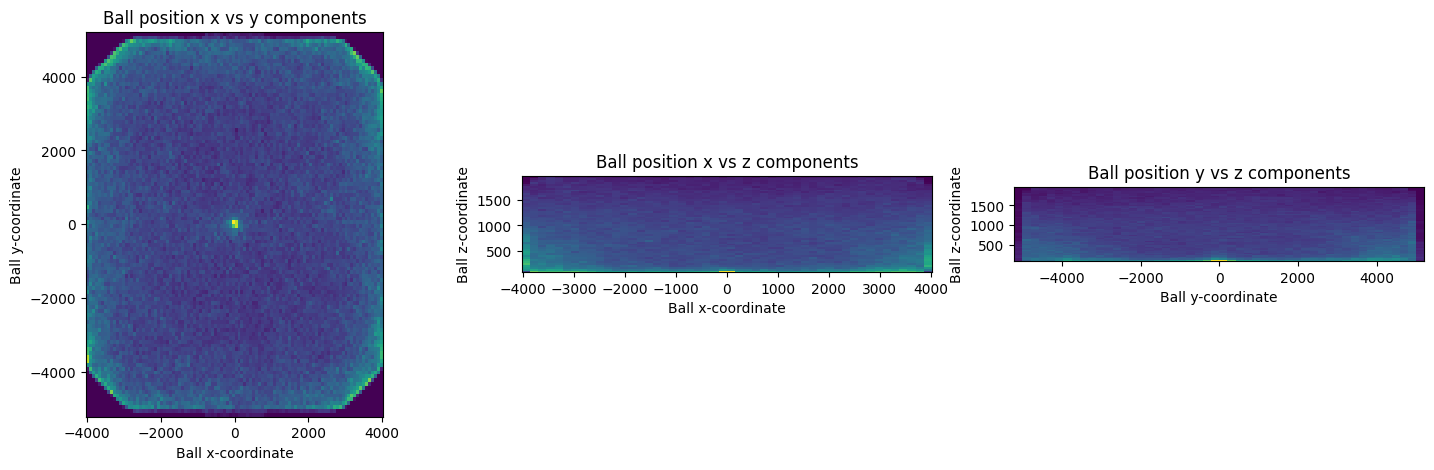

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.hist2d(ball_pos_all_segments[ball_cols_dict['position'][0]], ball_pos_all_segments[ball_cols_dict['position'][1]], cmap='viridis', bins=100)
ax1.set_aspect('equal')
ax1.set_xlabel('Ball x-coordinate')
ax1.set_ylabel('Ball y-coordinate')
ax1.set_title('Ball position x vs y components')

ax2.hist2d(ball_pos_all_segments[ball_cols_dict['position'][0]], ball_pos_all_segments[ball_cols_dict['position'][2]], cmap='viridis', bins=50)
ax2.set_aspect('equal')
ax2.set_xlabel('Ball x-coordinate')
ax2.set_ylabel('Ball z-coordinate')
ax2.set_title('Ball position x vs z components')

ax3.hist2d(ball_pos_all_segments[ball_cols_dict['position'][1]], ball_pos_all_segments[ball_cols_dict['position'][2]], cmap='viridis', bins=50)
ax3.set_aspect('equal')
ax3.set_xlabel('Ball y-coordinate')
ax3.set_ylabel('Ball z-coordinate')
ax3.set_title('Ball position y vs z components')

plt.show()

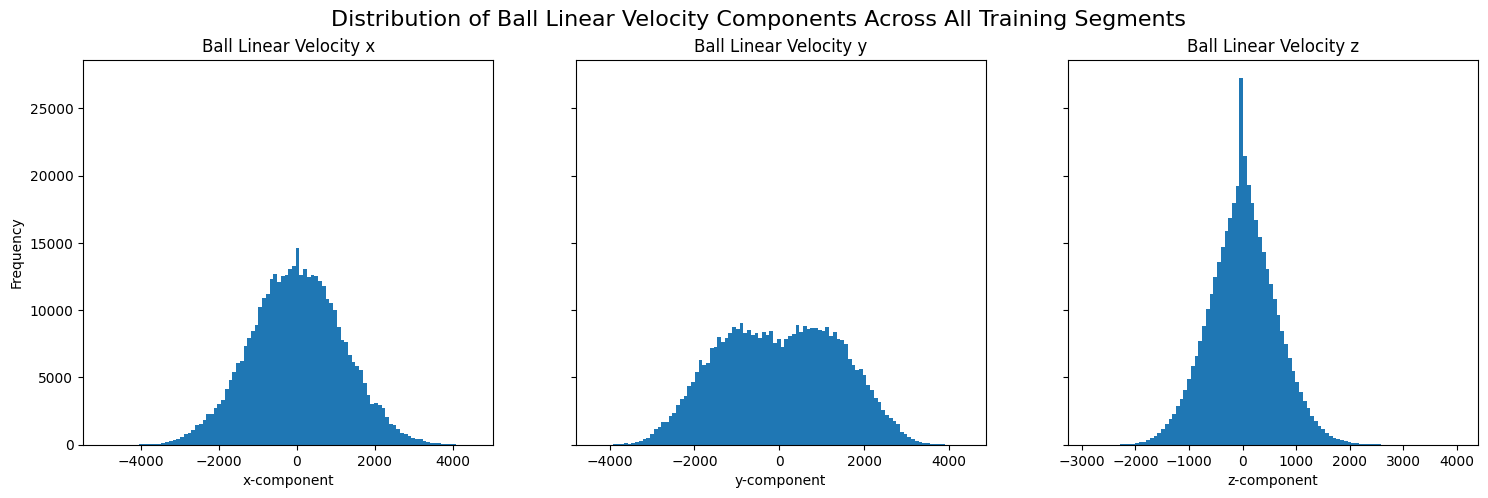

In [58]:
ball_linvel_all_segments = ball_frames_all_segments[ball_cols_dict['linear_velocity']]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
ax1.hist(ball_linvel_all_segments[ball_cols_dict['linear_velocity'][0]], bins=100)
ax1.set_xlabel('x-component')
ax1.set_ylabel('Frequency')
ax1.set_title('Ball Linear Velocity x')

ax2.hist(ball_linvel_all_segments[ball_cols_dict['linear_velocity'][1]], bins=100)
ax2.set_xlabel('y-component')
ax2.set_title('Ball Linear Velocity y')

ax3.hist(ball_linvel_all_segments[ball_cols_dict['linear_velocity'][2]], bins=100)
ax3.set_xlabel('z-component')
ax3.set_title('Ball Linear Velocity z')

fig.suptitle('Distribution of Ball Linear Velocity Components Across All Training Segments', fontsize=16)
plt.show()